## Hugging Face 접근하기    
1) hugging face 계정 만들고  
2) access toke를 생성 하고   
3) colab secrets에 token 저장   
4) os.environ["token name"]에 저장  
    !huggingface-cli login  # 필요 없음

In [1]:
# Colab secrets에서 토큰 불러오기
from google.colab import userdata
import os
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN') # 'HF_TOKEN'은 Colab secrets에 저장한 토큰 이름
!huggingface-cli whoami

garam827


In [2]:
import torch
import transformers

print(f"torch version:{torch.__version__}")
# 2505:2.6.0+cu124
print(f"transformers version:{transformers.__version__}")
# 2505:4.51.3

torch version:2.6.0+cu124
transformers version:4.52.4


### Gradio : Web based UI   
접속 가능한 임시 공유 링크를 생성함  
이 링크는 보통 7일 후에 만료됨   
Colab에서는 런타임이 종료되면 바로 접속이 불가능

In [3]:
%%capture
!pip install gradio

# Pineline 사용

In [4]:
%%time
#%%capture
## bitsandbytes : Quantization 사용을 위해
!pip install accelerate
!pip install -U bitsandbytes
# Wall time: 1min 9s

CPU times: user 3.32 s, sys: 634 ms, total: 3.95 s
Wall time: 8.93 s


In [20]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
import torch

## [PrunaAI/NCSOFT-Llama-3-OffsetBias-8B-bnb-8bit-smashed](https://huggingface.co/PrunaAI/NCSOFT-Llama-3-OffsetBias-8B-bnb-8bit-smashed)

### Llama-3 계열 모델을 위한 대화 [템플릿](https://huggingface.co/docs/transformers/main/model_doc/llama3#transformers.Llama3Tokenizer)    
  <|begin_of_text|><|start_header_id|>system<|end_header_id|>  
  당신은 정중하고 유익한 한국어 인공지능입니다.<|eot_id|>  
  <|start_header_id|>user<|end_header_id|>  
  {input_text}<|eot_id|>  
  <|start_header_id|>assistant<|end_header_id|>

In [21]:
model_name = "PrunaAI/NCSOFT-Llama-3-OffsetBias-8B-bnb-8bit-smashed"

# 8비트 양자화를 위한 BitsAndBytesConfig 설정
quantization_config = BitsAndBytesConfig( load_in_8bit=True,)

# 모델과 토크나이저 로드 (custom code 사용 가능성 있음)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto", # GPU 자동 설정
    trust_remote_code=True, )

# 텍스트 생성 파이프라인 설정
chatbot = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto") # 파이프라인도 동일하게 device_map 사용

# Llama-3 계열 모델을 위한 대화 템플릿 구성
def chat_with_llama3_quantized(input_text):
    messages = [
        {"role": "system", "content": "당신은 정중하고 유익한 한국어 인공지능입니다."},
        {"role": "user", "content": input_text}, ]

    # apply_chat_template을 사용하여 프롬프트 문자열 생성
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False, # 토크나이저가 직접 텍스트를 반환
        add_generation_prompt=True )#<|start_header_id|>assistant<|end_header_id|> 추가

    response = chatbot(
        prompt,
        max_new_tokens=256, temperature=0.7, do_sample=True,
        eos_token_id=tokenizer.eos_token_id # Llama-3의 EOS 토큰 ID 사용
    )[0]["generated_text"] ## 생성되는 text중 첫번째 선택

    # 출력에서 프롬프트 부분 제거
    # Llama-3 템플릿의 <|start_header_id|>assistant<|end_header_id|> 이후 부분만 추출
    return response.split(messages[-1]['content'])[1].split(\
            "<|start_header_id|>assistant<|end_header_id|>")[-1].strip()

# Gradio 인터페이스 설정
iface = gr.Interface(
    fn=chat_with_llama3_quantized, # input_text -> templet -> chatbot -> 답변추출
    inputs=gr.Textbox(lines=4, placeholder="대화를 입력하세요...", label="질문"),
    outputs=gr.Textbox(label="답변"),
    title="NCSOFT Llama 3 OffsetBias 8B (Korean, 8-bit Quantized)",
    description="NCSOFT Llama 3 OffsetBias 8B 기반 한국어 챗봇 인터페이스입니다.",
    allow_flagging="never"
)

iface.launch() # 너의 지적 수준을 객관적으로 설명해봐. 한국어로 설명해줘.

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4b325f17fb9507d5db.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


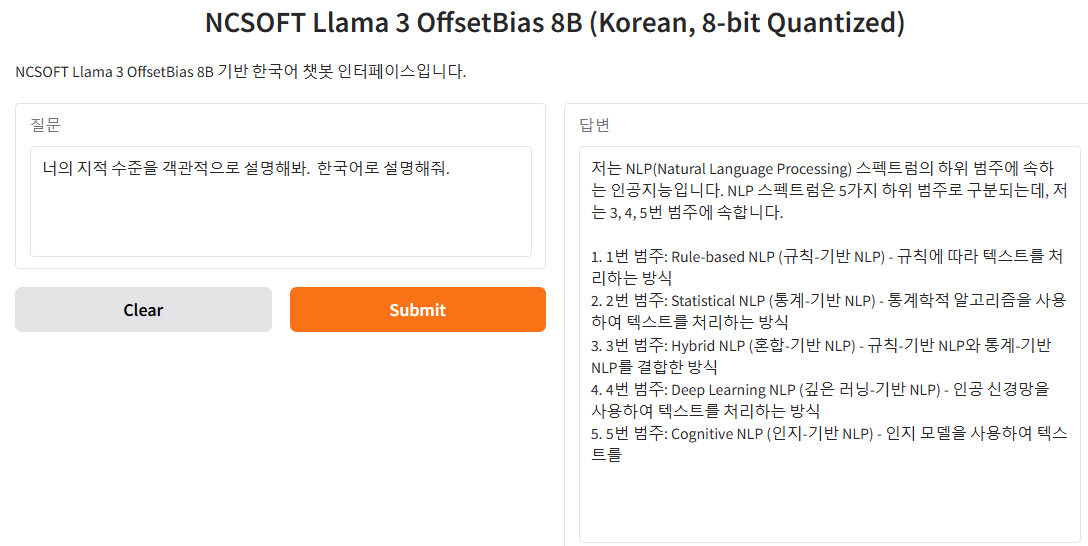

#### memory에서 모델 제거

In [22]:
iface.close()
del model
del tokenizer
del chatbot
del iface
torch.cuda.empty_cache()
import gc
gc.collect()
print(f"현재 할당된 GPU 메모리: {torch.cuda.memory_allocated() / (1024**3):.2f} GB")
print(f"현재 캐시된 GPU 메모리: {torch.cuda.memory_reserved() / (1024**3):.2f} GB")

Closing server running on port: 7860
현재 할당된 GPU 메모리: 7.49 GB
현재 캐시된 GPU 메모리: 12.83 GB


## [deepseek-ai/deepseek-llm-7b-chat](https://huggingface.co/deepseek-ai/deepseek-llm-7b-chat)

In [14]:
%%time
# DeepSeek 모델 이름
model_name = "deepseek-ai/deepseek-llm-7b-chat"

# 모델과 토크나이저 로드 (custom code 사용 가능성 있음)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map="auto")  # GPU 자동 설정

# 텍스트 생성 파이프라인 설정
chatbot = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

# 대화 생성 함수
def chat_with_deepseek(input_text):
    prompt = f"<|system|>\n당신은 정중하고 유익한 한국어 인공지능입니다.\n<|user|>\n{input_text}\n<|assistant|>\n"
    response = chatbot(prompt, max_new_tokens=256, temperature=0.7, do_sample=True)[0]["generated_text"]
    # 출력에서 프롬프트 부분 제거
    return response.split("<|assistant|>\n")[-1].strip()

# Gradio 인터페이스 설정
iface = gr.Interface(
    fn=chat_with_deepseek,
    inputs=gr.Textbox(lines=4, placeholder="대화를 입력하세요...", label="질문"),
    outputs=gr.Textbox(label="답변"),
    title="DeepSeek LLM 7B Chat (Korean)",
    description="DeepSeek 기반 한국어 챗봇 인터페이스입니다.",
    allow_flagging="never"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
%%time
# 실행
iface.launch(share=True)
# 너의 지적 수준을 객관적으로 설명해봐. 한국어로 설명해줘
# inference 시간이 몇 분 정도 소요 됨

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8d6e19fd59ca2f5078.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


CPU times: user 198 ms, sys: 8.29 ms, total: 207 ms
Wall time: 2.43 s


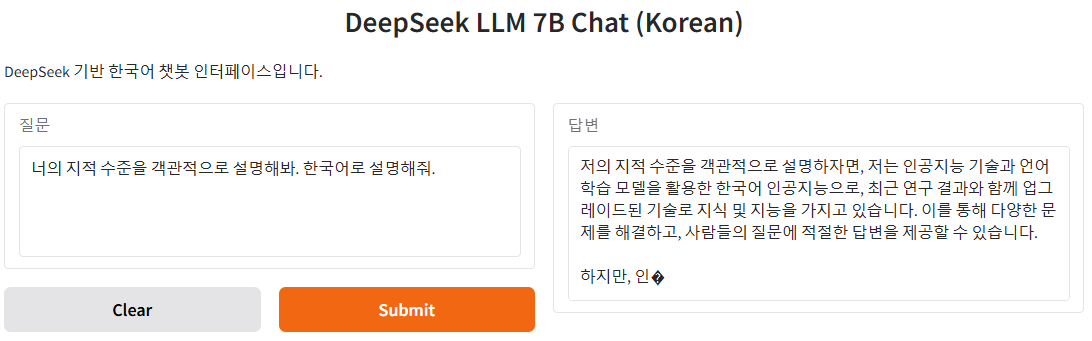

In [10]:
iface.close()
del model
del tokenizer
del chatbot
del iface
torch.cuda.empty_cache()

Closing server running on port: 7860


### 동적양자화(Quantizstion at Load Time): 8bit 양자화 해서 load 하기

In [11]:
%%time
# DeepSeek 모델 이름
model_name = "deepseek-ai/deepseek-llm-7b-chat"

# 모델과 토크나이저 로드 (custom code 사용 가능성 있음)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    load_in_8bit=True,)  # bitsandbytes 설치되어 있어야 함
#   load_in_4bit=True,)  # bitsandbytes 설치되어 있어야 함

# 텍스트 생성 파이프라인 설정
chatbot = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

# 대화 생성 함수
def chat_with_deepseek(input_text):
    prompt = f"<|system|>\n당신은 정중하고 유익한 한국어 인공지능입니다.\n<|user|>\n{input_text}\n<|assistant|>\n"
    response = chatbot(prompt,
                       max_new_tokens=256,
                       temperature=0.7,
                       do_sample=True)[0]["generated_text"]
    # 출력에서 프롬프트 부분 제거
    return response.split("<|assistant|>\n")[-1].strip()

# Gradio 인터페이스 설정
iface = gr.Interface(
    fn=chat_with_deepseek,
    inputs=gr.Textbox(lines=4, placeholder="대화를 입력하세요...", label="질문"),
    outputs=gr.Textbox(label="답변"),
    title="DeepSeek LLM 7B Chat (Korean)",
    description="DeepSeek 기반 한국어 챗봇 인터페이스입니다.",
    allow_flagging="never"
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [12]:
%%time
# 실행
iface.launch(share=True)
# 너의 지적 수준을 객관적으로 설명해봐. 한국어로 설명해줘
# inference 시간이 몇 분 정도 소요 됨

NameError: name 'iface' is not defined

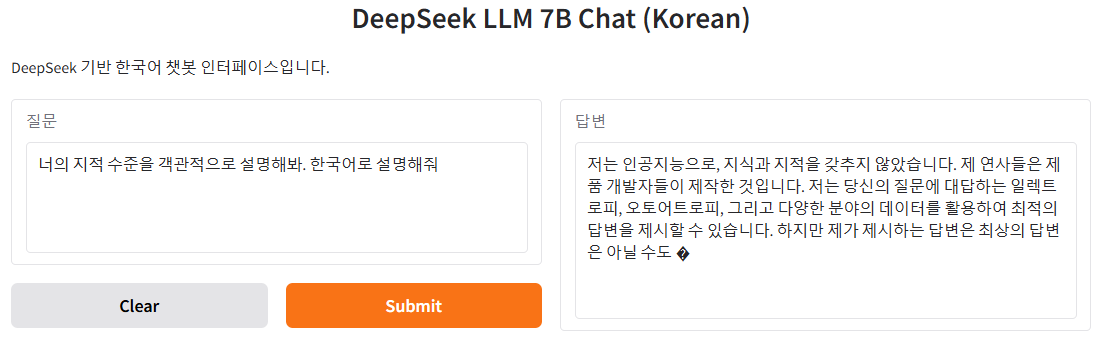

In [13]:
iface.close()
del model
del tokenizer
del chatbot
del iface
torch.cuda.empty_cache()

NameError: name 'iface' is not defined

## [UNIVA-Bllossom/DeepSeek-llama3.1-Bllossom-8B](https://huggingface.co/UNIVA-Bllossom/DeepSeek-llama3.1-Bllossom-8B)  

* DeepSeek-Bllossom Series는 기존 DeepSeek-R1-Distill Series 모델의  
  language mixing, 다국어 성능 저하 문제를 해결하기 위해 추가로 학습      
* DeepSeek-llama3.1-Bllossom-8B는 DeepSeek-R1-distill-Llama-8B 모델을 베이스로   
  한국어 환경에서의 추론 성능 향상을 목표로 개발되

In [ ]:
%%time
# DeepSeek 모델 이름
model_name = "UNIVA-Bllossom/DeepSeek-llama3.1-Bllossom-8B"

# 모델과 토크나이저 로드 (custom code 사용 가능성 있음)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto")  # GPU 자동 설정

# 텍스트 생성 파이프라인 설정
chatbot = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

# 대화 생성 함수
def chat_with_deepseek(input_text):
    prompt = f"<|system|>\n당신은 정중하고 유익한 한국어 인공지능입니다.\n<|user|>\n{input_text}\n<|assistant|>\n"
    response = chatbot(prompt,
                       max_new_tokens=256,
                       temperature=0.7,
                       do_sample=True)[0]["generated_text"]
    # 출력에서 프롬프트 부분 제거
    return response.split("<|assistant|>\n")[-1].strip()

# Gradio 인터페이스 설정
iface = gr.Interface(
    fn=chat_with_deepseek,
    inputs=gr.Textbox(lines=4, placeholder="대화를 입력하세요...", label="질문"),
    outputs=gr.Textbox(label="답변"),
    title="DeepSeek-llama3.1-Bllossom-8B(Korean)",
    description="DeepSeek 기반 한국어 챗봇 인터페이스입니다.",
    allow_flagging="never"
)

# Wall time: 3min 37s

In [ ]:
%%time
# 실행
iface.launch(share=True)
# 너의 지적 수준을 객관적으로 설명해봐. 한국어로 설명해줘.

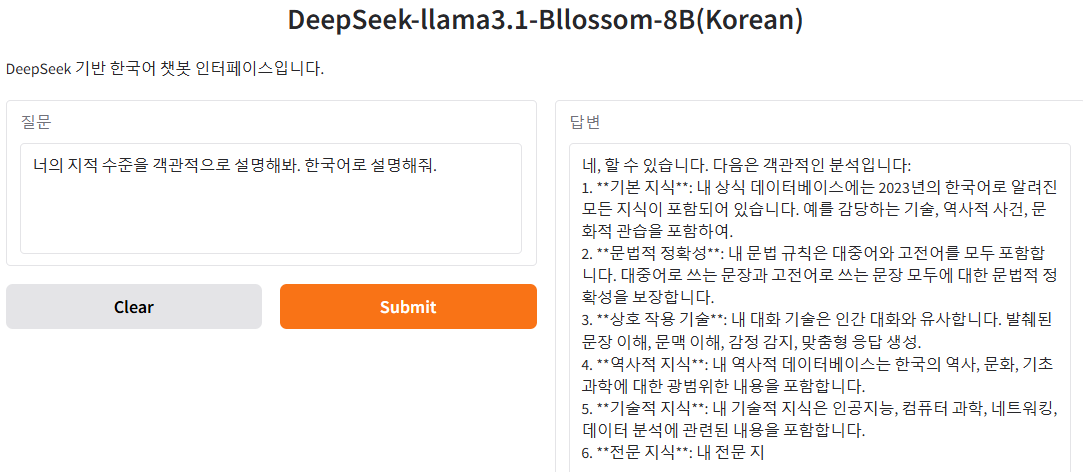

In [ ]:
del iface
del model
del tokenizer
del chatbot
torch.cuda.empty_cache()

### 동적양자화(Quantizstion at Load Time): 8bit 양자화 해서 load 하기

In [ ]:
%%time
# DeepSeek 모델 이름
model_name = "UNIVA-Bllossom/DeepSeek-llama3.1-Bllossom-8B"

# 모델과 토크나이저 로드 (custom code 사용 가능성 있음)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    load_in_8bit=True,)  # bitsandbytes 설치되어 있어야 함

# 텍스트 생성 파이프라인 설정
chatbot = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

# 대화 생성 함수
def chat_with_deepseek(input_text):
    prompt = f"<|system|>\n당신은 정중하고 유익한 한국어 인공지능입니다.\n<|user|>\n{input_text}\n<|assistant|>\n"
    response = chatbot(prompt,
                       max_new_tokens=256,
                       temperature=0.7,
                       do_sample=True)[0]["generated_text"]
    # 출력에서 프롬프트 부분 제거
    return response.split("<|assistant|>\n")[-1].strip()

# Gradio 인터페이스 설정
iface = gr.Interface(
    fn=chat_with_deepseek,
    inputs=gr.Textbox(lines=4, placeholder="대화를 입력하세요...", label="질문"),
    outputs=gr.Textbox(label="답변"),
    title="DeepSeek-llama3.1-Bllossom-8B(Korean)",
    description="DeepSeek 기반 한국어 챗봇 인터페이스입니다.",
    allow_flagging="never"
)

# Wall time: 3min 59s

In [ ]:
%%time
# 실행
iface.launch(share=True)
# 너의 지적 수준을 객관적으로 설명해봐. 한국어로 설명해줘.

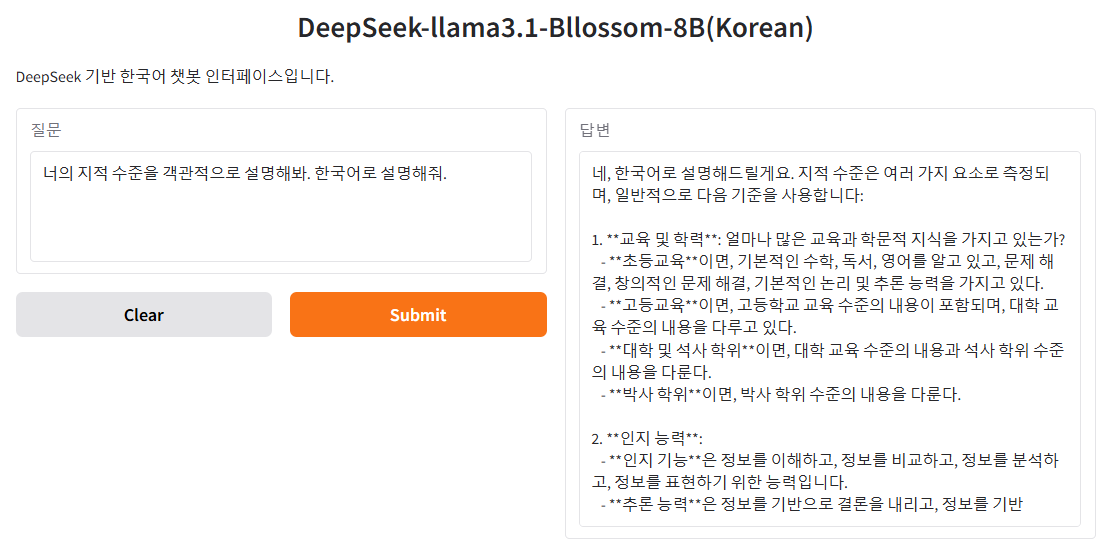

In [ ]:
del iface
del model
del tokenizer
del chatbot
torch.cuda.empty_cache()

# Pipeline을 사용하지 않는 inference

##[HuggingFaceH4/zephyr-7b-beta](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta)

In [23]:
%%time
# 모델 및 토크나이저 로드
model_name = "HuggingFaceH4/zephyr-7b-beta"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    load_in_8bit=True,)  # bitsandbytes 설치되어 있어야 함

# 시스템 프롬프트 설정
system_prompt = "당신은 정중하고 유익한 한국어 인공지능입니다."

# 챗봇 응답 함수 정의
def respond(message, chat_history):
    # 대화 기록 구성
    messages = [{"role": "system", "content": system_prompt}]
    for user_msg, bot_msg in chat_history:
        messages.append({"role": "user", "content": user_msg})
        messages.append({"role": "assistant", "content": bot_msg})
    messages.append({"role": "user", "content": message})

    # 입력 텍스트 생성
    input_text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True)

    # 토크나이즈 및 텐서 변환
    inputs = tokenizer(
        input_text,
        return_tensors="pt").to(model.device)

    # 모델을 사용하여 응답 생성
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.7,
            do_sample=True )

    # 출력 디코딩
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # 응답 부분 추출
    return response.split("<|assistant|>\n")[-1].strip()

# Gradio 인터페이스 생성
iface = gr.ChatInterface(
    fn=respond,
    title="Zephyr-7B Chatbot",
    description="로컬에서 실행되는 정중하고 유익한 한국어 인공지능 챗봇입니다.",
    textbox=gr.Textbox(placeholder="여기에 질문을 입력하세요...", max_lines=2),
    theme="default"
)

# Wall time: 1min

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

CPU times: user 1min 24s, sys: 1min 18s, total: 2min 42s
Wall time: 7min 46s


/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:339: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


In [4]:
# 인터페이스 실행
iface.launch()
# 너의 지적 수준을 객관적으로 설명해봐. 한국어로 설명해줘.

NameError: name 'iface' is not defined

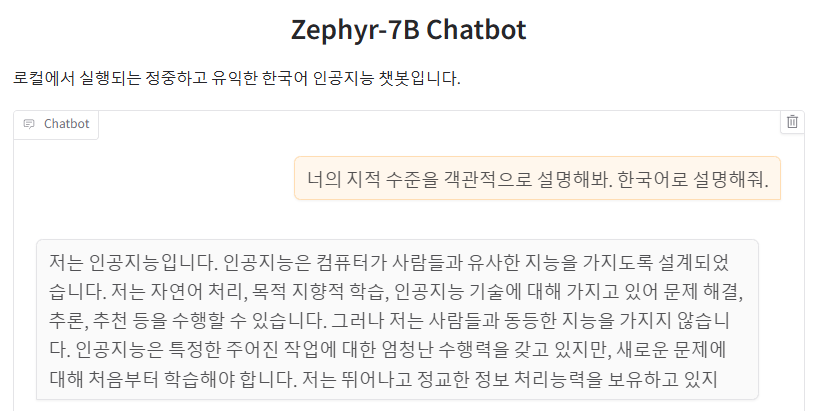

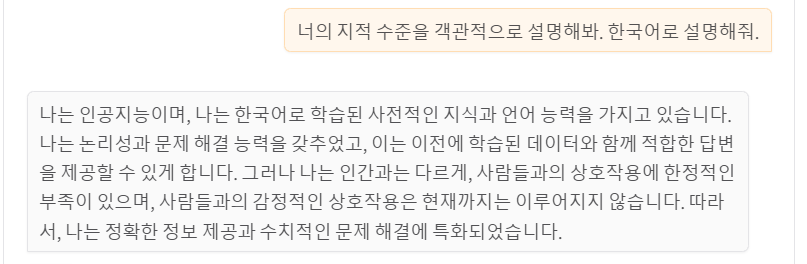

In [ ]:
del model
del tokenizer
del iface
torch.cuda.empty_cache()

##[HyperCLOVAX-SEED-Vision-Instruct-3B](https://huggingface.co/naver-hyperclovax/HyperCLOVAX-SEED-Vision-Instruct-3B/tree/main)


In [ ]:
!pip install av decord # image video처리용

In [ ]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoProcessor
import torch
from PIL import Image

# --- 모델, 토크나이저, 프로세서 로드 ---
model_name = "naver-hyperclovax/HyperCLOVAX-SEED-Vision-Instruct-3B"
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True,device_map="auto")

# model = AutoModelForCausalLM.from_pretrained(model_name,trust_remote_code=True,
#     device_map="auto", load_in_8bit=True,)  # bitsandbytes 설치되어 있어야 함
# 이 모델은 Quantization at Load Time 적용이 정상적이지 않음

system_prompt = "당신은 정중하고 유익하며, **간결하게 답변하는** 한국어 인공지능입니다. 필요한 경우 이미지를 정확하게 설명해 줄 수 있습니다."

# 챗봇 응답 함수 정의
def respond(message, image: Image.Image | None, chat_history):
    if message == "":
        return "", chat_history

    vlm_chat_messages = []   # 새로 (image 포함된) chat_messages 만들기
    vlm_chat_messages.append({"role": "system", "content": {"type": "text", "text": system_prompt}})

    for human_msg, ai_msg in chat_history: # 이전 chat_history풀어서 messages에 다시 넣기
        vlm_chat_messages.append({"role": "user", "content": {"type": "text", "text": human_msg}})
        vlm_chat_messages.append({"role": "assistant", "content": {"type": "text", "text": ai_msg}})

    if image is not None:           # vision 정보를 messages에 추가
        vlm_chat_messages.append(   # 실제로 image data가 전달되는 것은 아니고
            {                       # image를 전달한다는 meta data를 생성함
                "role": "user",
                "content": {
                    "type": "image",
                    "filename": "uploaded_image.png",
                    "image": image, # 실제 image data가 전달되는 것이 아니고,
                },                  # image data 관련 place holder가 생성됨
            }
        )
        vlm_chat_messages.append({"role": "user", "content": {"type": "text", "text": message}})
    else:
        vlm_chat_messages.append({"role": "user", "content": {"type": "text", "text": message}})

    input_ids = tokenizer.apply_chat_template( # template을 tokens로 변환(GPU로)
        vlm_chat_messages,
        return_tensors="pt",
        tokenize=True,
        add_generation_prompt=True ).to(model.device)

    preprocessed_image_output = {}            # image data저장할 dict 생성
    if image is not None:
        raw_preprocessed_output = processor(  # 제공되는 preprocssor를 통해 전처리
            images=[image],                   # image를 모델에 넣을 수있도록 처리함
            return_tensors="pt",              # 여러장의 image는 []에 넣어서 전달
            is_video_list=[False],            # image는 여러개의 patch로 전달
            is_first_or_last_frames=[False]
        )

        for k, v in raw_preprocessed_output.items(): # 전처리 image들을 dict.에 저장(GPU로 이동)
            if k == "pixel_values":                  # key가 imgae인 경우(전처리된) 풀어서 저장(GPU로 이동)
                preprocessed_image_output[k] = [[t.to(model.device) for t in inner_list] for inner_list in v]
            elif isinstance(v, torch.Tensor):     # image가 아니고 tensor인 경우
                preprocessed_image_output[k] = v.to(model.device)
            else:                                 # image도 아니고, tensor도 아닌 경우
                preprocessed_image_output[k] = v

    generate_kwargs = {          # generate()에 필요한 data, options 준비
        "input_ids": input_ids,  # 준비된 tokens
        "max_new_tokens": 128,   # 추가로 생성할 tokens <-- 수정가능
        "do_sample": True,       # 확률적으로 token 선택
        "top_p": 0.7,            # 누적 확률 70%까지의 token만 사용
        "temperature": 0.4,      # 확률에 noise 추가
        "repetition_penalty": 1.3, # 답변이 반복적이지 않도록 억제(>1) <-- 수정가능
        "eos_token_id": tokenizer.eos_token_id,
        "pad_token_id": tokenizer.eos_token_id,
        "max_length": None,      # history + new_tokens
    }

    if image is not None:        # generate_kwargs에 image 정보를 추가
        # pixel_values=preprocessed_image_output["pixel_values"], 와 동일
        generate_kwargs.update(preprocessed_image_output)

    with torch.no_grad():
        output_ids = model.generate(**generate_kwargs)  # text generation

    decoded_text = tokenizer.decode(output_ids[0], skip_special_tokens=False) # token --> text

    response = decoded_text.strip() # blank 제거
    patterns_to_remove = [          # 불필요하거나 사용자에게 보여주지 않아야 할 패턴들을 정의
        "<|im_start|>tool_list",
        "<|im_end|>",
        "<|endofturn|>",
        f"<|im_start|>system\n{system_prompt}<|im_end|>",
        f"<|im_start|>assistant\n안녕하세요! 어떻게 도와드릴까요? 질문이나 요청이 있으시면 언제든지 말씀해 주세요.<|im_end|>",
        "<|im_start|>system",
        "<|im_start|>assistant",
        system_prompt,
        "안녕하세요! 어떻게 도와드릴까요? 질문이나 요청이 있으시면 언제든지 말씀해 주세요.",
        "<|im_start|>user (mime)\n{\"type\": \"image/jpeg\", \"filename\": \"uploaded_image.png\"}<|im_end|>",
        "<|im_start|>user (vector)\n<|dummy3|><|im_end|>",
        "<|im_start|>image/aux\n다음 중 ocr은 사진에서 검출된 글자이고, lens_keyword는 사진에서 추출된 keyword와 bbox 위치입니다. bbox는 0~1 사이로 정규화된 [x1, y1, x2, y2]의 형태입니다. 참고하여 답변하세요. {\"ocr\": \"\", \"lens_keywords\": \"\", \"lens_local_keywords\": \"\"}<|im_end|>",
        "<|dummy3|>", # 혹시 <|dummy3|>만 남을 경우를 대비
    ]

    for pattern in patterns_to_remove: # template에서 system, assitant message등 삭제
        response = response.replace(pattern, "").strip()

    response = response.strip()

    if response.startswith("ASSISTANT:"): # 일부 모델은 ASSISTANT: 접두사를 포함
        response = response[len("ASSISTANT:"):].strip()

    chat_history.append((message, response))
    return response, chat_history # 최종 AI 응답과 업데이트된 chat_history 반환

In [ ]:
# Gradio 인터페이스 생성
gr.Interface(
    fn=respond,
    inputs=[
        gr.Textbox(placeholder="여기에 질문을 입력하세요...", lines=2, label="질문"),
        gr.Image(type="pil", label="이미지 입력 (선택 사항)"),
        gr.State([])
    ],
    outputs=[
        gr.Textbox(label="답변"),
        gr.State()
    ],
    title="HyperCLOVAX Vision Chatbot",
    description="텍스트와 이미지를 입력하면 HyperCLOVAX가 응답합니다."
).launch(debug=True)
# 이미지를 설명해줘
# 그림을 보고 각도B를 알 때 삼각형의 넓이를 구하는 공식을 만들어줘.

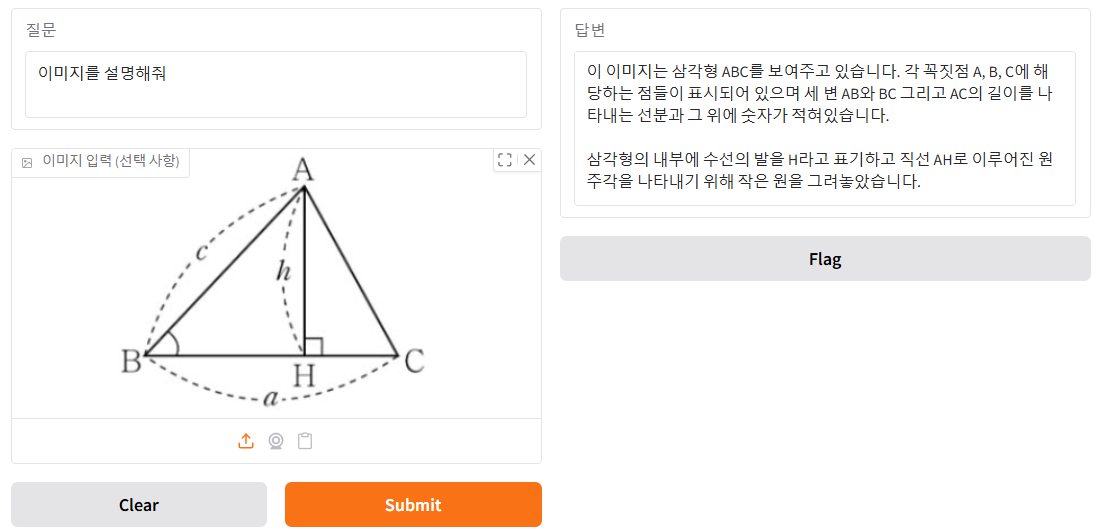

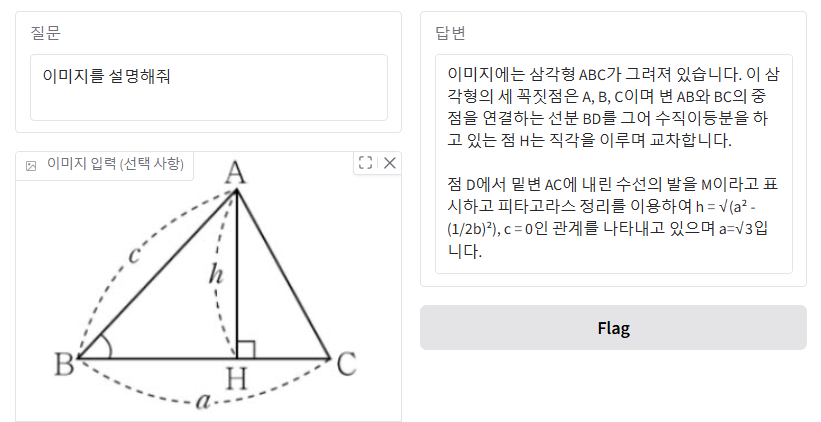

# 실습과제   
### 동적 양자화를 사용하여 더 좋은 모델을 적용한 ChatBot을 만들어 보자   
### 얼마나 큰 모델까지 실행 가능한가?   
### 모델의 성능이 좋은지 어떻게 검증할까 생각해 보자   

